## Import necessary libraries

In [14]:
# Import necessary libraries
import os
import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam
from sklearn.model_selection import train_test_split
import shutil

In [15]:
# Define paths
dataset_path = "./dataset"  # Path to the original dataset
output_path = "./split_dataset"  # Path to save the split dataset
train_ratio = 0.7
val_ratio = 0.15
test_ratio = 0.15

In [16]:
# Ensure output directories exist
for split in ["train", "val", "test"]:
    for class_name in os.listdir(dataset_path):
        os.makedirs(os.path.join(output_path, split, class_name), exist_ok=True)

In [17]:
# Split data
for class_name in os.listdir(dataset_path):
    class_path = os.path.join(dataset_path, class_name)
    if not os.path.isdir(class_path):
        continue

    # Get all file names
    files = [f for f in os.listdir(class_path) if os.path.isfile(os.path.join(class_path, f))]

    # Split into train, val, and test
    train_files, temp_files = train_test_split(files, test_size=(1 - train_ratio), random_state=42)
    val_files, test_files = train_test_split(temp_files, test_size=(test_ratio / (test_ratio + val_ratio)), random_state=42)

    # Move files
    for file in train_files:
        shutil.copy(os.path.join(class_path, file), os.path.join(output_path, "train", class_name, file))
    for file in val_files:
        shutil.copy(os.path.join(class_path, file), os.path.join(output_path, "val", class_name, file))
    for file in test_files:
        shutil.copy(os.path.join(class_path, file), os.path.join(output_path, "test", class_name, file))

print("Dataset successfully split into train, val, and test sets!")

KeyboardInterrupt: 

In [ ]:
# Parameters
IMG_HEIGHT = 224
IMG_WIDTH = 224
BATCH_SIZE = 32
EPOCHS = 60

In [ ]:
# Data generators for training, validation, and testing data
train_datagen = ImageDataGenerator(rescale=1.0/255.0)

train_generator = train_datagen.flow_from_directory(
    os.path.join(output_path, "train"),
    target_size=(IMG_HEIGHT, IMG_WIDTH),
    batch_size=BATCH_SIZE,
    class_mode='binary',
    shuffle=True  # Shuffle the training data
)

val_datagen = ImageDataGenerator(rescale=1.0/255.0)

val_generator = val_datagen.flow_from_directory(
    os.path.join(output_path, "val"),
    target_size=(IMG_HEIGHT, IMG_WIDTH),
    batch_size=BATCH_SIZE,
    class_mode='binary',
    shuffle=False  # Do not shuffle the validation data
)

test_datagen = ImageDataGenerator(rescale=1.0/255.0)

test_generator = test_datagen.flow_from_directory(
    os.path.join(output_path, "test"),
    target_size=(IMG_HEIGHT, IMG_WIDTH),
    batch_size=BATCH_SIZE,
    class_mode='binary',
    shuffle=False  # Do not shuffle the test data
)

Found 29254 images belonging to 2 classes.
Found 6269 images belonging to 2 classes.
Found 6270 images belonging to 2 classes.


## Check the dataset balance and calculate class weights based on the class distribution. The model will use these weights during training if the dataset is imbalanced.

In [ ]:
from collections import Counter

In [ ]:
# Check dataset balance
class_counts = Counter(train_generator.classes)
print("Dataset class distribution:")
for class_label, count in class_counts.items():
    print(f"Class {class_label}: {count} images")

Dataset class distribution:
Class 0: 15643 images
Class 1: 13611 images


In [ ]:
# Calculate class weights if needed
total_images = sum(class_counts.values())
class_weights = {class_label: total_images / (len(class_counts) * count) for class_label, count in class_counts.items()}
print("Class weights:", class_weights)

Class weights: {0: 0.9350508214536853, 1: 1.0746455073102636}


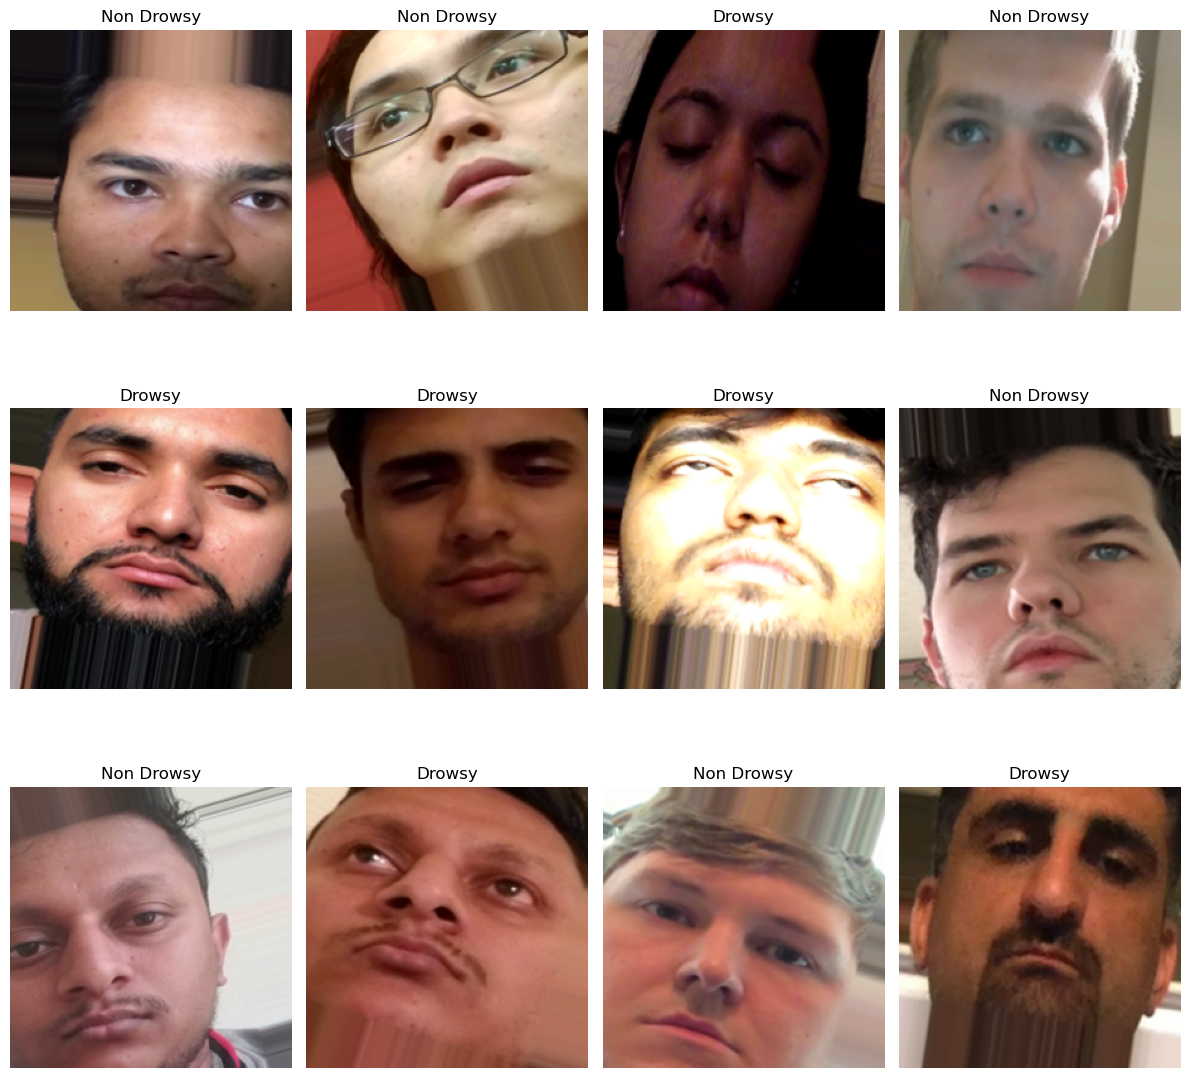

In [ ]:
# Display some images from the dataset
sample_images, sample_labels = next(train_generator)
plt.figure(figsize=(12, 12))
for i in range(12):
    plt.subplot(3, 4, i + 1)
    plt.imshow(sample_images[i])
    plt.title("Drowsy" if sample_labels[i] == 0 else "Non Drowsy")
    plt.axis('off')
plt.tight_layout()
plt.show()

In [ ]:
# Build a new model from scratch
model = Sequential()
model.add(Conv2D(16, (3, 3), activation='relu', input_shape=(IMG_HEIGHT, IMG_WIDTH, 3)))
model.add(MaxPooling2D((2, 2)))
model.add(Conv2D(32, (3, 3), activation='relu'))
model.add(MaxPooling2D((2, 2)))
model.add(Conv2D(64, (3, 3), activation='relu'))
model.add(MaxPooling2D((2, 2)))
model.add(Flatten())
model.add(Dense(64, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(1, activation='sigmoid'))

/home/tyson/development/miniconda3/envs/tf/lib/python3.9/site-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
I0000 00:00:1733679139.141221   15924 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 6717 MB memory:  -> device: 0, name: NVIDIA GeForce GTX 1070, pci bus id: 0000:01:00.0, compute capability: 6.1


In [ ]:
# Compile the model
model.compile(optimizer=Adam(learning_rate=0.001), loss='binary_crossentropy', metrics=['accuracy'])

In [ ]:
# Train the model
history = model.fit(
    train_generator,
    validation_data=val_generator,
    epochs=EPOCHS,
    steps_per_epoch=len(train_generator),
    validation_steps=len(val_generator)
)

/home/tyson/development/miniconda3/envs/tf/lib/python3.9/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/60


I0000 00:00:1733679142.853341   17157 service.cc:148] XLA service 0x7f2c1c004960 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1733679142.853399   17157 service.cc:156]   StreamExecutor device (0): NVIDIA GeForce GTX 1070, Compute Capability 6.1
2024-12-09 00:32:22.895309: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:268] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
I0000 00:00:1733679143.178872   17157 cuda_dnn.cc:529] Loaded cuDNN version 90300
2024-12-09 00:32:23.982229: I external/local_xla/xla/service/gpu/autotuning/conv_algorithm_picker.cc:557] Omitted potentially buggy algorithm eng14{} for conv (f32[32,16,222,222]{3,2,1,0}, u8[0]{0}) custom-call(f32[32,3,224,224]{3,2,1,0}, f32[16,3,3,3]{3,2,1,0}, f32[16]{0}), window={size=3x3}, dim_labels=bf01_oi01->bf01, custom_call_target="__cudnn$convBiasActivationForward", backend_config={"cudnn_conv_backend_config":{"activati

  1/915 ━━━━━━━━━━━━━━━━━━━━ 1:32:06 6s/step - accuracy: 0.5000 - loss: 0.6892

I0000 00:00:1733679147.116246   17157 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


569/915 ━━━━━━━━━━━━━━━━━━━━ 2:14 390ms/step - accuracy: 0.6864 - loss: 0.5709

2024-12-09 00:36:09.073949: I external/local_xla/xla/service/gpu/autotuning/conv_algorithm_picker.cc:557] Omitted potentially buggy algorithm eng14{} for conv (f32[6,16,222,222]{3,2,1,0}, u8[0]{0}) custom-call(f32[6,3,224,224]{3,2,1,0}, f32[16,3,3,3]{3,2,1,0}, f32[16]{0}), window={size=3x3}, dim_labels=bf01_oi01->bf01, custom_call_target="__cudnn$convBiasActivationForward", backend_config={"cudnn_conv_backend_config":{"activation_mode":"kNone","conv_result_scale":1,"leakyrelu_alpha":0,"side_input_scale":0},"force_earliest_schedule":false,"operation_queue_id":"0","wait_on_operation_queues":[]}
2024-12-09 00:36:09.197150: I external/local_xla/xla/service/gpu/autotuning/conv_algorithm_picker.cc:557] Omitted potentially buggy algorithm eng14{} for conv (f32[6,32,109,109]{3,2,1,0}, u8[0]{0}) custom-call(f32[6,16,111,111]{3,2,1,0}, f32[32,16,3,3]{3,2,1,0}, f32[32]{0}), window={size=3x3}, dim_labels=bf01_oi01->bf01, custom_call_target="__cudnn$convBiasActivationForward", backend_config={"cudn

915/915 ━━━━━━━━━━━━━━━━━━━━ 0s 389ms/step - accuracy: 0.7317 - loss: 0.5081

2024-12-09 00:38:24.038761: I external/local_xla/xla/service/gpu/autotuning/conv_algorithm_picker.cc:557] Omitted potentially buggy algorithm eng14{} for conv (f32[32,16,222,222]{3,2,1,0}, u8[0]{0}) custom-call(f32[32,3,224,224]{3,2,1,0}, f32[16,3,3,3]{3,2,1,0}, f32[16]{0}), window={size=3x3}, dim_labels=bf01_oi01->bf01, custom_call_target="__cudnn$convBiasActivationForward", backend_config={"cudnn_conv_backend_config":{"activation_mode":"kRelu","conv_result_scale":1,"leakyrelu_alpha":0,"side_input_scale":0},"force_earliest_schedule":false,"operation_queue_id":"0","wait_on_operation_queues":[]}
2024-12-09 00:38:24.092250: I external/local_xla/xla/service/gpu/autotuning/conv_algorithm_picker.cc:557] Omitted potentially buggy algorithm eng14{} for conv (f32[32,32,109,109]{3,2,1,0}, u8[0]{0}) custom-call(f32[32,16,111,111]{3,2,1,0}, f32[32,16,3,3]{3,2,1,0}, f32[32]{0}), window={size=3x3}, dim_labels=bf01_oi01->bf01, custom_call_target="__cudnn$convBiasActivationForward", backend_config={"

915/915 ━━━━━━━━━━━━━━━━━━━━ 381s 410ms/step - accuracy: 0.7318 - loss: 0.5080 - val_accuracy: 0.9730 - val_loss: 0.1079
Epoch 2/60
915/915 ━━━━━━━━━━━━━━━━━━━━ 369s 404ms/step - accuracy: 0.9385 - loss: 0.1640 - val_accuracy: 0.9831 - val_loss: 0.0388
Epoch 3/60
514/915 ━━━━━━━━━━━━━━━━━━━━ 2:37 392ms/step - accuracy: 0.9700 - loss: 0.0855

KeyboardInterrupt: 

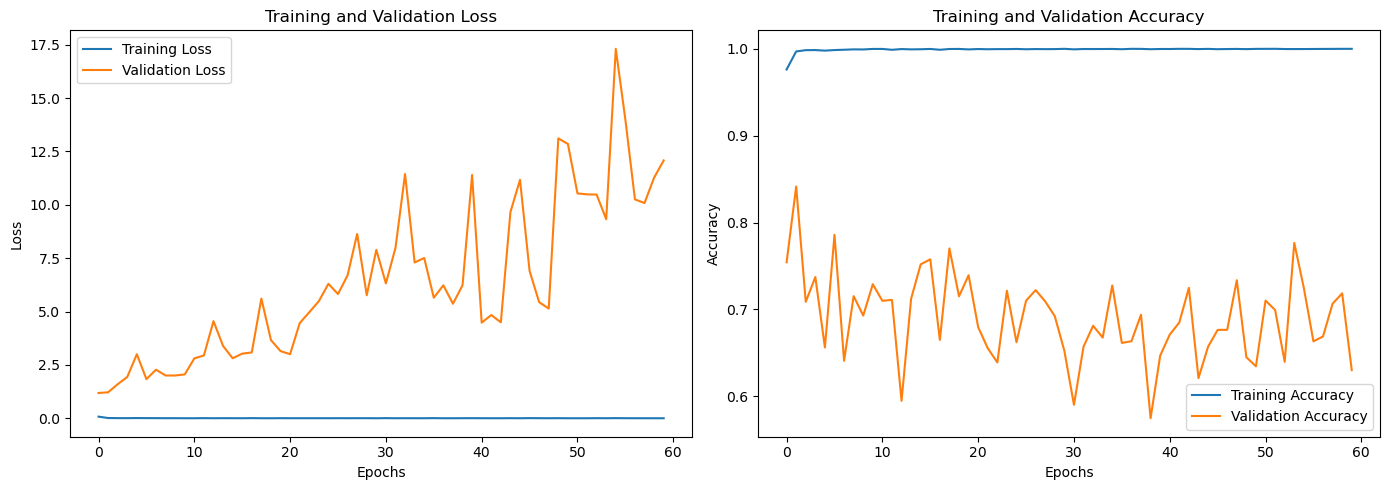

In [ ]:
# Evaluate the model on the test set
test_loss, test_accuracy = model.evaluate(test_generator, steps=test_generator.samples // BATCH_SIZE)

# Plot training, validation, and test results
plt.figure(figsize=(14, 5))

# Plot loss
plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.axhline(y=test_loss, color='r', linestyle='--', label='Test Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training, Validation, and Test Loss')
plt.legend()

# Plot accuracy
plt.subplot(1, 2, 2)
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.axhline(y=test_accuracy, color='r', linestyle='--', label='Test Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Training, Validation, and Test Accuracy')
plt.legend()

plt.tight_layout()
plt.show()

# Plot training and validation loss and accuracy
plt.figure(figsize=(14, 5))

# Plot loss
plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()

# Plot accuracy
plt.subplot(1, 2, 2)
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Training and Validation Accuracy')
plt.legend()

plt.tight_layout()
plt.show()

# Print training and validation loss and accuracy
train_loss = history.history['loss']
train_accuracy = history.history['accuracy']
val_loss = history.history['val_loss']
val_accuracy = history.history['val_accuracy']

print(f"Final Training Loss: {train_loss[-1]:.4f}")
print(f"Final Training Accuracy: {train_accuracy[-1]:.4f}")
print(f"Final Validation Loss: {val_loss[-1]:.4f}")
print(f"Final Validation Accuracy: {val_accuracy[-1]:.4f}")
print(f"Test Loss: {test_loss:.4f}")
print(f"Test Accuracy: {test_accuracy:.4f}")


## L2 Regularization

In [ ]:
from tensorflow.keras.regularizers import l2

In [ ]:
# Build a new model from scratch with L2 regularization
model = Sequential()
model.add(Conv2D(16, (3, 3), activation='relu', kernel_regularizer=l2(0.01), input_shape=(IMG_HEIGHT, IMG_WIDTH, 3)))
model.add(MaxPooling2D((2, 2)))
model.add(Conv2D(32, (3, 3), activation='relu', kernel_regularizer=l2(0.01)))
model.add(MaxPooling2D((2, 2)))
model.add(Conv2D(64, (3, 3), activation='relu', kernel_regularizer=l2(0.01)))
model.add(MaxPooling2D((2, 2)))
model.add(Flatten())
model.add(Dense(64, activation='relu', kernel_regularizer=l2(0.01)))
model.add(Dropout(0.5))
model.add(Dense(1, activation='sigmoid', kernel_regularizer=l2(0.01)))

In [ ]:
# Compile the model
model.compile(optimizer=Adam(learning_rate=0.001), loss='binary_crossentropy', metrics=['accuracy'])

In [ ]:
# Train the model
history = model.fit(
    train_generator,
    validation_data=val_generator,
    epochs=EPOCHS,
    steps_per_epoch=len(train_generator),
    validation_steps=len(val_generator)
)

Epoch 1/60
 682/1045 ━━━━━━━━━━━━━━━━━━━━ 31s 86ms/step - accuracy: 0.8524 - loss: 0.9630

2024-12-08 03:32:26.400337: I external/local_xla/xla/stream_executor/cuda/cuda_asm_compiler.cc:397] ptxas warning : Registers are spilled to local memory in function 'input_add_reduce_subtract_fusion_1', 8 bytes spill stores, 8 bytes spill loads



1045/1045 ━━━━━━━━━━━━━━━━━━━━ 113s 105ms/step - accuracy: 0.8774 - loss: 0.8291 - val_accuracy: 0.6316 - val_loss: 1.7223
Epoch 2/60
1045/1045 ━━━━━━━━━━━━━━━━━━━━ 107s 103ms/step - accuracy: 0.9549 - loss: 0.3424 - val_accuracy: 0.6936 - val_loss: 1.2505
Epoch 3/60
1045/1045 ━━━━━━━━━━━━━━━━━━━━ 109s 104ms/step - accuracy: 0.9547 - loss: 0.3131 - val_accuracy: 0.6793 - val_loss: 1.6120
Epoch 4/60
1045/1045 ━━━━━━━━━━━━━━━━━━━━ 108s 103ms/step - accuracy: 0.9572 - loss: 0.2935 - val_accuracy: 0.7374 - val_loss: 1.1763
Epoch 5/60
1045/1045 ━━━━━━━━━━━━━━━━━━━━ 108s 104ms/step - accuracy: 0.9597 - loss: 0.2772 - val_accuracy: 0.6249 - val_loss: 1.8877
Epoch 6/60
1045/1045 ━━━━━━━━━━━━━━━━━━━━ 107s 102ms/step - accuracy: 0.9645 - loss: 0.2620 - val_accuracy: 0.6316 - val_loss: 1.7630
Epoch 7/60
1045/1045 ━━━━━━━━━━━━━━━━━━━━ 108s 103ms/step - accuracy: 0.9729 - loss: 0.2409 - val_accuracy: 0.6034 - val_loss: 2.1194
Epoch 8/60
1045/1045 ━━━━━━━━━━━━━━━━━━━━ 110s 105ms/step - accuracy: 0.9

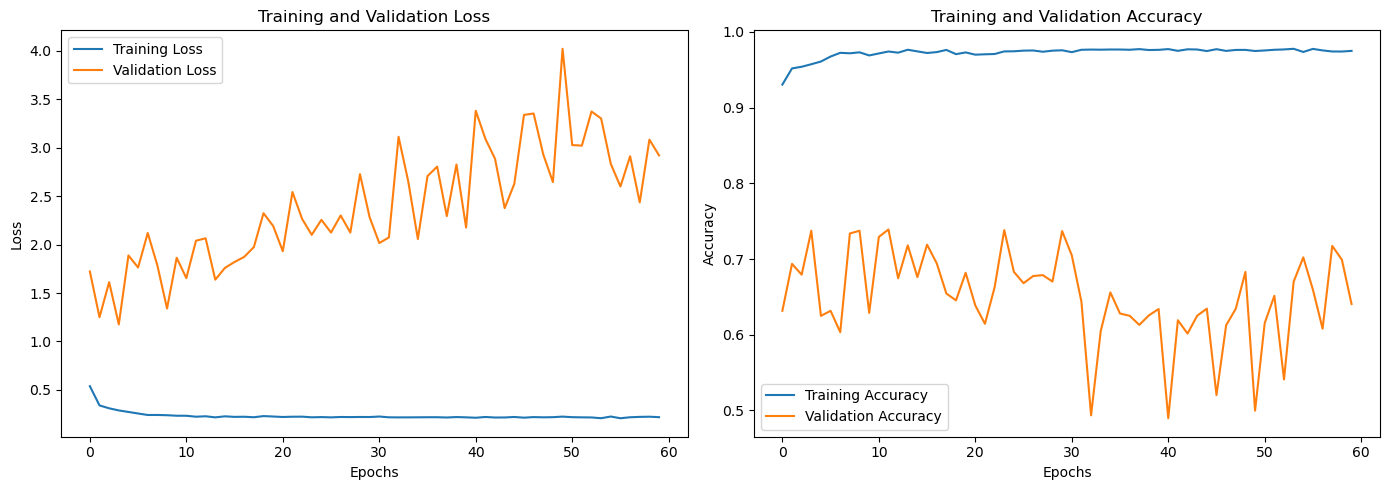

In [ ]:
# Evaluate the model on the test set
test_loss, test_accuracy = model.evaluate(test_generator, steps=test_generator.samples // BATCH_SIZE)

# Plot training, validation, and test results
plt.figure(figsize=(14, 5))

# Plot loss
plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.axhline(y=test_loss, color='r', linestyle='--', label='Test Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training, Validation, and Test Loss')
plt.legend()

# Plot accuracy
plt.subplot(1, 2, 2)
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.axhline(y=test_accuracy, color='r', linestyle='--', label='Test Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Training, Validation, and Test Accuracy')
plt.legend()

plt.tight_layout()
plt.show()

# Plot training and validation loss and accuracy
plt.figure(figsize=(14, 5))

# Plot loss
plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()

# Plot accuracy
plt.subplot(1, 2, 2)
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Training and Validation Accuracy')
plt.legend()

plt.tight_layout()
plt.show()

# Print training and validation loss and accuracy
train_loss = history.history['loss']
train_accuracy = history.history['accuracy']
val_loss = history.history['val_loss']
val_accuracy = history.history['val_accuracy']

print(f"Final Training Loss: {train_loss[-1]:.4f}")
print(f"Final Training Accuracy: {train_accuracy[-1]:.4f}")
print(f"Final Validation Loss: {val_loss[-1]:.4f}")
print(f"Final Validation Accuracy: {val_accuracy[-1]:.4f}")
print(f"Test Loss: {test_loss:.4f}")
print(f"Test Accuracy: {test_accuracy:.4f}")

## Use early stopping to avoid unnecessary training once the model stops improving.

In [ ]:
from tensorflow.keras.callbacks import EarlyStopping

# Add EarlyStopping callback
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

## Add data augmentation to help improve model generalization.

In [ ]:
# Data generators for training, validation, and testing data with data augmentation
datagen = ImageDataGenerator(
    rescale=1.0/255.0,
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    horizontal_flip=False,
    fill_mode='nearest'
)

train_generator = datagen.flow_from_directory(
    os.path.join(output_path, "train"),
    target_size=(IMG_HEIGHT, IMG_WIDTH),
    batch_size=BATCH_SIZE,
    class_mode='binary',
    shuffle=True  # Shuffle the training data
)

val_datagen = ImageDataGenerator(rescale=1.0/255.0)

val_generator = val_datagen.flow_from_directory(
    os.path.join(output_path, "val"),
    target_size=(IMG_HEIGHT, IMG_WIDTH),
    batch_size=BATCH_SIZE,
    class_mode='binary',
    shuffle=False  # Do not shuffle the validation data
)

test_datagen = ImageDataGenerator(rescale=1.0/255.0)

test_generator = test_datagen.flow_from_directory(
    os.path.join(output_path, "test"),
    target_size=(IMG_HEIGHT, IMG_WIDTH),
    batch_size=BATCH_SIZE,
    class_mode='binary',
    shuffle=False  # Do not shuffle the test data
)

Found 33435 images belonging to 2 classes.
Found 8358 images belonging to 2 classes.


## Increased the L2 regularization strength to 0.05

In [ ]:
# Build a new model from scratch with increased L2 regularization strength
model = Sequential()
model.add(Conv2D(16, (3, 3), activation='relu', kernel_regularizer=l2(0.05), input_shape=(IMG_HEIGHT, IMG_WIDTH, 3)))
model.add(MaxPooling2D((2, 2)))
model.add(Conv2D(32, (3, 3), activation='relu', kernel_regularizer=l2(0.05)))
model.add(MaxPooling2D((2, 2)))
model.add(Conv2D(64, (3, 3), activation='relu', kernel_regularizer=l2(0.05)))
model.add(MaxPooling2D((2, 2)))
model.add(Flatten())
model.add(Dense(64, activation='relu', kernel_regularizer=l2(0.05)))
model.add(Dropout(0.5))
model.add(Dense(1, activation='sigmoid', kernel_regularizer=l2(0.05)))

/home/tyson/development/miniconda3/envs/tf/lib/python3.9/site-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [ ]:
# Compile the model
model.compile(optimizer=Adam(learning_rate=0.001), loss='binary_crossentropy', metrics=['accuracy'])

In [ ]:
# Train the model
history = model.fit(
    train_generator,
    validation_data=val_generator,
    epochs=EPOCHS,
    steps_per_epoch=len(train_generator),
    validation_steps=len(val_generator),
    callbacks=[early_stopping]
)

Epoch 1/60
1045/1045 ━━━━━━━━━━━━━━━━━━━━ 431s 409ms/step - accuracy: 0.5271 - loss: 1.5615 - val_accuracy: 0.5347 - val_loss: 0.7008
Epoch 2/60
1045/1045 ━━━━━━━━━━━━━━━━━━━━ 388s 371ms/step - accuracy: 0.5348 - loss: 0.6992 - val_accuracy: 0.5347 - val_loss: 0.6919
Epoch 3/60
1045/1045 ━━━━━━━━━━━━━━━━━━━━ 379s 362ms/step - accuracy: 0.5360 - loss: 0.6914 - val_accuracy: 0.5347 - val_loss: 0.6910
Epoch 4/60
1045/1045 ━━━━━━━━━━━━━━━━━━━━ 383s 367ms/step - accuracy: 0.5328 - loss: 0.6912 - val_accuracy: 0.5347 - val_loss: 0.6910
Epoch 5/60
1045/1045 ━━━━━━━━━━━━━━━━━━━━ 384s 368ms/step - accuracy: 0.5340 - loss: 0.6912 - val_accuracy: 0.5347 - val_loss: 0.6913
Epoch 6/60
1045/1045 ━━━━━━━━━━━━━━━━━━━━ 396s 379ms/step - accuracy: 0.5362 - loss: 0.6910 - val_accuracy: 0.5347 - val_loss: 0.6912
Epoch 7/60
1045/1045 ━━━━━━━━━━━━━━━━━━━━ 380s 364ms/step - accuracy: 0.5343 - loss: 0.6913 - val_accuracy: 0.5347 - val_loss: 0.6911
Epoch 8/60
1045/1045 ━━━━━━━━━━━━━━━━━━━━ 381s 365ms/step - ac

KeyboardInterrupt: 

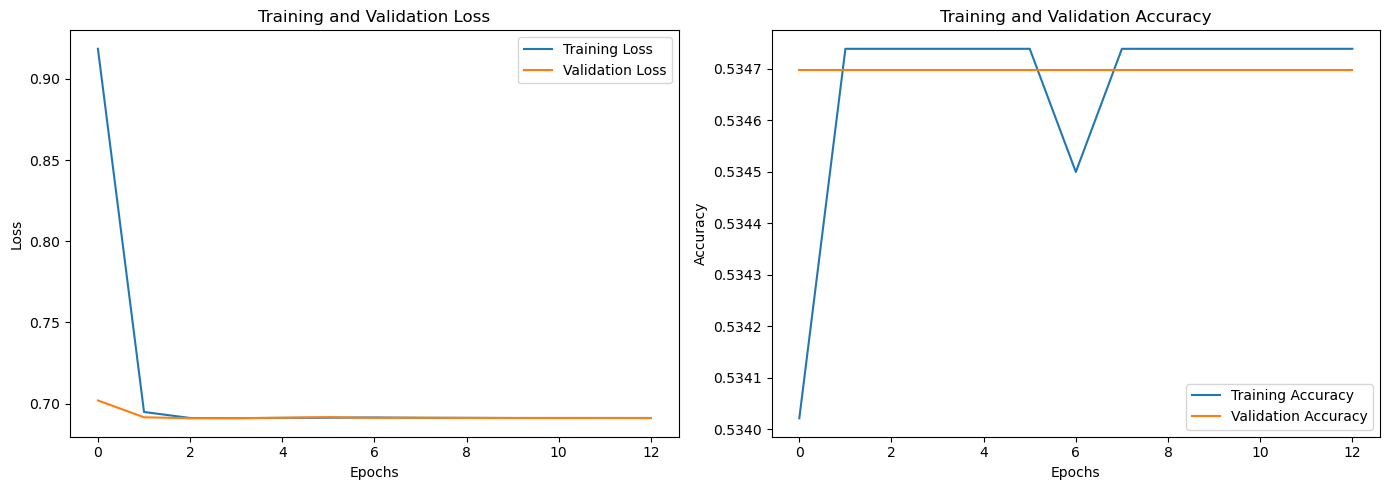

Final Training Loss: 0.6911
Final Training Accuracy: 0.5347
Final Validation Loss: 0.6911
Final Validation Accuracy: 0.5347


In [ ]:
# Evaluate the model on the test set
test_loss, test_accuracy = model.evaluate(test_generator, steps=test_generator.samples // BATCH_SIZE)

# Plot training, validation, and test results
plt.figure(figsize=(14, 5))

# Plot loss
plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.axhline(y=test_loss, color='r', linestyle='--', label='Test Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training, Validation, and Test Loss')
plt.legend()

# Plot accuracy
plt.subplot(1, 2, 2)
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.axhline(y=test_accuracy, color='r', linestyle='--', label='Test Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Training, Validation, and Test Accuracy')
plt.legend()

plt.tight_layout()
plt.show()

# Plot training and validation loss and accuracy
plt.figure(figsize=(14, 5))

# Plot loss
plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()

# Plot accuracy
plt.subplot(1, 2, 2)
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Training and Validation Accuracy')
plt.legend()

plt.tight_layout()
plt.show()

# Print training and validation loss and accuracy
train_loss = history.history['loss']
train_accuracy = history.history['accuracy']
val_loss = history.history['val_loss']
val_accuracy = history.history['val_accuracy']

print(f"Final Training Loss: {train_loss[-1]:.4f}")
print(f"Final Training Accuracy: {train_accuracy[-1]:.4f}")
print(f"Final Validation Loss: {val_loss[-1]:.4f}")
print(f"Final Validation Accuracy: {val_accuracy[-1]:.4f}")
print(f"Test Loss: {test_loss:.4f}")
print(f"Test Accuracy: {test_accuracy:.4f}")

# Increase Batch Size to 64

In [ ]:
BATCH_SIZE = 64

# Decrease the L2 regularization coefficien to 0.01

In [ ]:
model = Sequential()
model.add(Conv2D(16, (3, 3), activation='relu', kernel_regularizer=l2(0.01), input_shape=(IMG_HEIGHT, IMG_WIDTH, 3)))
model.add(MaxPooling2D((2, 2)))
model.add(Conv2D(32, (3, 3), activation='relu', kernel_regularizer=l2(0.01)))
model.add(MaxPooling2D((2, 2)))
model.add(Conv2D(64, (3, 3), activation='relu', kernel_regularizer=l2(0.01)))
model.add(MaxPooling2D((2, 2)))
model.add(Flatten())
model.add(Dense(64, activation='relu', kernel_regularizer=l2(0.01)))
model.add(Dropout(0.5))
model.add(Dense(1, activation='sigmoid', kernel_regularizer=l2(0.01)))

In [ ]:
# Compile the model
model.compile(optimizer=Adam(learning_rate=0.001), loss='binary_crossentropy', metrics=['accuracy'])

In [ ]:
# Train the model
history = model.fit(
    train_generator,
    validation_data=val_generator,
    epochs=EPOCHS,
    steps_per_epoch=len(train_generator),
    validation_steps=len(val_generator),
    callbacks=[early_stopping]
)

Epoch 1/60
 663/1045 ━━━━━━━━━━━━━━━━━━━━ 2:47 438ms/step - accuracy: 0.5701 - loss: 0.9105

2024-12-08 19:13:10.076487: I external/local_xla/xla/stream_executor/cuda/cuda_asm_compiler.cc:397] ptxas warning : Registers are spilled to local memory in function 'input_add_reduce_subtract_fusion_1', 8 bytes spill stores, 8 bytes spill loads



1045/1045 ━━━━━━━━━━━━━━━━━━━━ 492s 466ms/step - accuracy: 0.5879 - loss: 0.8448 - val_accuracy: 0.6033 - val_loss: 0.6351
Epoch 2/60
1045/1045 ━━━━━━━━━━━━━━━━━━━━ 462s 442ms/step - accuracy: 0.6815 - loss: 0.6495 - val_accuracy: 0.5686 - val_loss: 0.7328
Epoch 3/60
1045/1045 ━━━━━━━━━━━━━━━━━━━━ 466s 446ms/step - accuracy: 0.7329 - loss: 0.6169 - val_accuracy: 0.6807 - val_loss: 0.7818
Epoch 4/60
1045/1045 ━━━━━━━━━━━━━━━━━━━━ 472s 452ms/step - accuracy: 0.7506 - loss: 0.5932 - val_accuracy: 0.6926 - val_loss: 0.9344
Epoch 5/60
1045/1045 ━━━━━━━━━━━━━━━━━━━━ 470s 450ms/step - accuracy: 0.7682 - loss: 0.5796 - val_accuracy: 0.6582 - val_loss: 0.8716
Epoch 6/60
1045/1045 ━━━━━━━━━━━━━━━━━━━━ 466s 446ms/step - accuracy: 0.7685 - loss: 0.5696 - val_accuracy: 0.6476 - val_loss: 1.1158
Epoch 7/60
1045/1045 ━━━━━━━━━━━━━━━━━━━━ 466s 446ms/step - accuracy: 0.8000 - loss: 0.5639 - val_accuracy: 0.6500 - val_loss: 1.0787
Epoch 8/60
 766/1045 ━━━━━━━━━━━━━━━━━━━━ 1:58 425ms/step - accuracy: 0.8

KeyboardInterrupt: 

In [ ]:
# Evaluate the model on the test set
test_loss, test_accuracy = model.evaluate(test_generator, steps=test_generator.samples // BATCH_SIZE)

# Plot training, validation, and test results
plt.figure(figsize=(14, 5))

# Plot loss
plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.axhline(y=test_loss, color='r', linestyle='--', label='Test Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training, Validation, and Test Loss')
plt.legend()

# Plot accuracy
plt.subplot(1, 2, 2)
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.axhline(y=test_accuracy, color='r', linestyle='--', label='Test Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Training, Validation, and Test Accuracy')
plt.legend()

plt.tight_layout()
plt.show()

# Plot training and validation loss and accuracy
plt.figure(figsize=(14, 5))

# Plot loss
plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()

# Plot accuracy
plt.subplot(1, 2, 2)
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Training and Validation Accuracy')
plt.legend()

plt.tight_layout()
plt.show()

# Print training and validation loss and accuracy
train_loss = history.history['loss']
train_accuracy = history.history['accuracy']
val_loss = history.history['val_loss']
val_accuracy = history.history['val_accuracy']

print(f"Final Training Loss: {train_loss[-1]:.4f}")
print(f"Final Training Accuracy: {train_accuracy[-1]:.4f}")
print(f"Final Validation Loss: {val_loss[-1]:.4f}")
print(f"Final Validation Accuracy: {val_accuracy[-1]:.4f}")
print(f"Test Loss: {test_loss:.4f}")
print(f"Test Accuracy: {test_accuracy:.4f}")